In [5]:
import os, json, shutil, random
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import torch
from sklearn.metrics import confusion_matrix, f1_score

from thop import profile

from InferenceEngine import InferenceEngine

In [9]:
# def work(save_path):
#     val_path = "../dataset/val-50"
#     InferenceEngine0 = InferenceEngine()

#     infer_info = {"img_name":[],
#                 "true_idx":[],
#                 "predict_idx":[],
#                 "food_name":[],
#                 "confidence":[],
#                 "inference_time":[]
#                 }

#     for i in tqdm(os.listdir(val_path)):
#         img_path = os.path.join(val_path, i)
#         food_info = InferenceEngine0.inference(img_path)
#         if food_info["success"]:
#             infer_info["img_name"].append(i)
#             infer_info["true_idx"].append(int(i.split("-")[1]))
#             infer_info["predict_idx"].append(food_info["class_idx"])
#             infer_info["food_name"].append(food_info["food_name"])
#             infer_info["confidence"].append(food_info["confidence"])
#             infer_info["inference_time"].append(food_info["inference_time"])
#         else:
#             print(f"error: {food_info}")

#     infer_info = pd.DataFrame(infer_info)
#     infer_info.to_csv(save_path, index=False)

# work("infer_info_resnet.csv")

In [2]:
def work(model_name):
    val_path = "../dataset/val-50-v1"
    InferenceEngine0 = InferenceEngine(model_name)

    infer_info = {"img_name":[],
                "true_idx":[],
                "predict_idx":[],
                "food_name":[],
                "confidence":[],
                "inference_time":[]
                }

    for i in tqdm(os.listdir(val_path)):
        img_path = os.path.join(val_path, i)
        food_info = InferenceEngine0.inference(img_path)
        if food_info["success"]:
            infer_info["img_name"].append(i)
            infer_info["true_idx"].append(int(i.split("-")[1]))
            infer_info["predict_idx"].append(food_info["class_idx"])
            infer_info["food_name"].append(food_info["food_name"])
            infer_info["confidence"].append(food_info["confidence"])
            infer_info["inference_time"].append(food_info["inference_time"])
        else:
            print(f"error: {food_info}")
    # 转为DataFrame
    infer_info_df = pd.DataFrame(infer_info)
    
    # 绘制混淆矩阵
    cm = confusion_matrix(infer_info_df["true_idx"], infer_info_df["predict_idx"])
    plt.figure(figsize=(10, 10), dpi=500)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
                xticklabels=range(50), yticklabels=range(50))
    plt.title(model_name)
    plt.xlabel('预测类别')
    plt.ylabel('真实类别')
    plt.tight_layout()
    plt.show()
    
    # 计算相关指标
    print(f"model_name: {model_name}")
    avg_acc = (np.sum(infer_info_df["true_idx"] == infer_info_df["predict_idx"]) / len(infer_info_df)).item()
    avg_confidence = infer_info_df["confidence"].mean().item()
    avg_inference_time = infer_info_df["inference_time"].mean().item()
    f1 = f1_score(infer_info_df["true_idx"], infer_info_df["predict_idx"], average='weighted')
    print(f"acc: {avg_acc:.4f}, F1 score: {f1:.4f}, avg_confidence: {avg_confidence:.4f}, avg_inference_time: {avg_inference_time:.4f}")

use : vgg


100%|██████████| 800/800 [00:07<00:00, 100.28it/s]


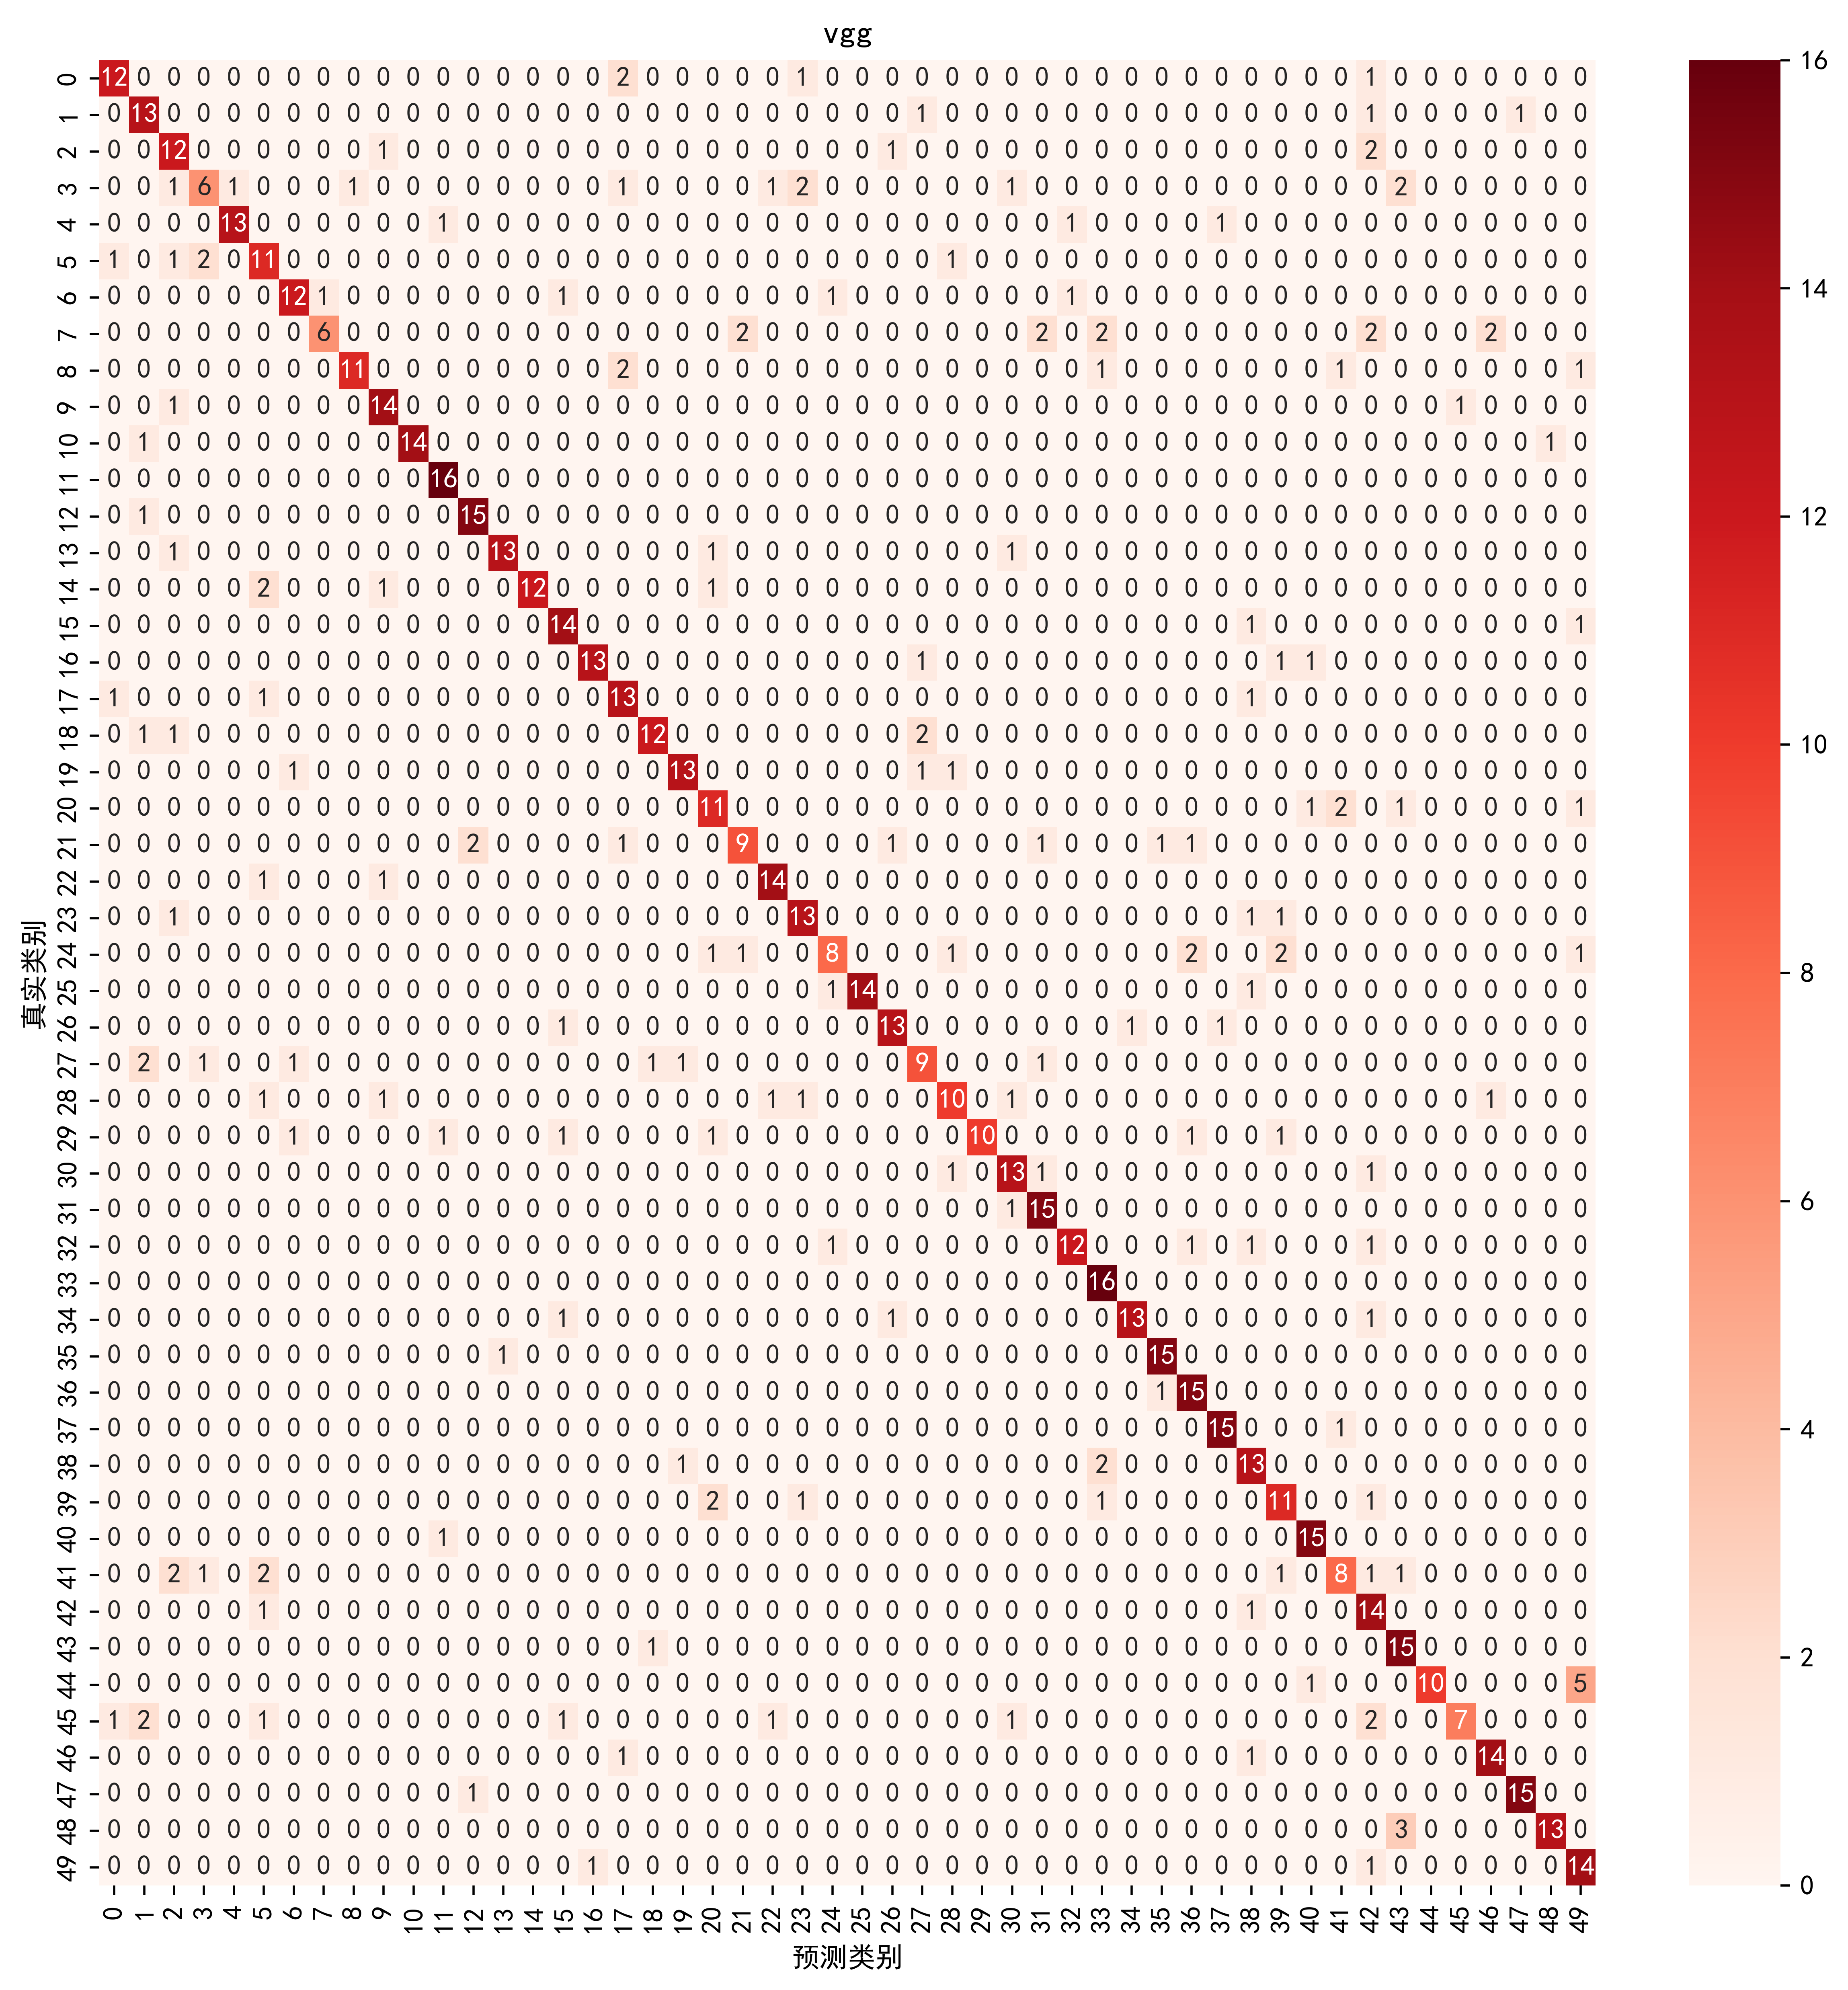

model_name: vgg
acc: 0.7738, F1 score: 0.7707, avg_confidence: 89.7671, avg_inference_time: 0.0099
use : resnet


100%|██████████| 800/800 [00:05<00:00, 142.04it/s]


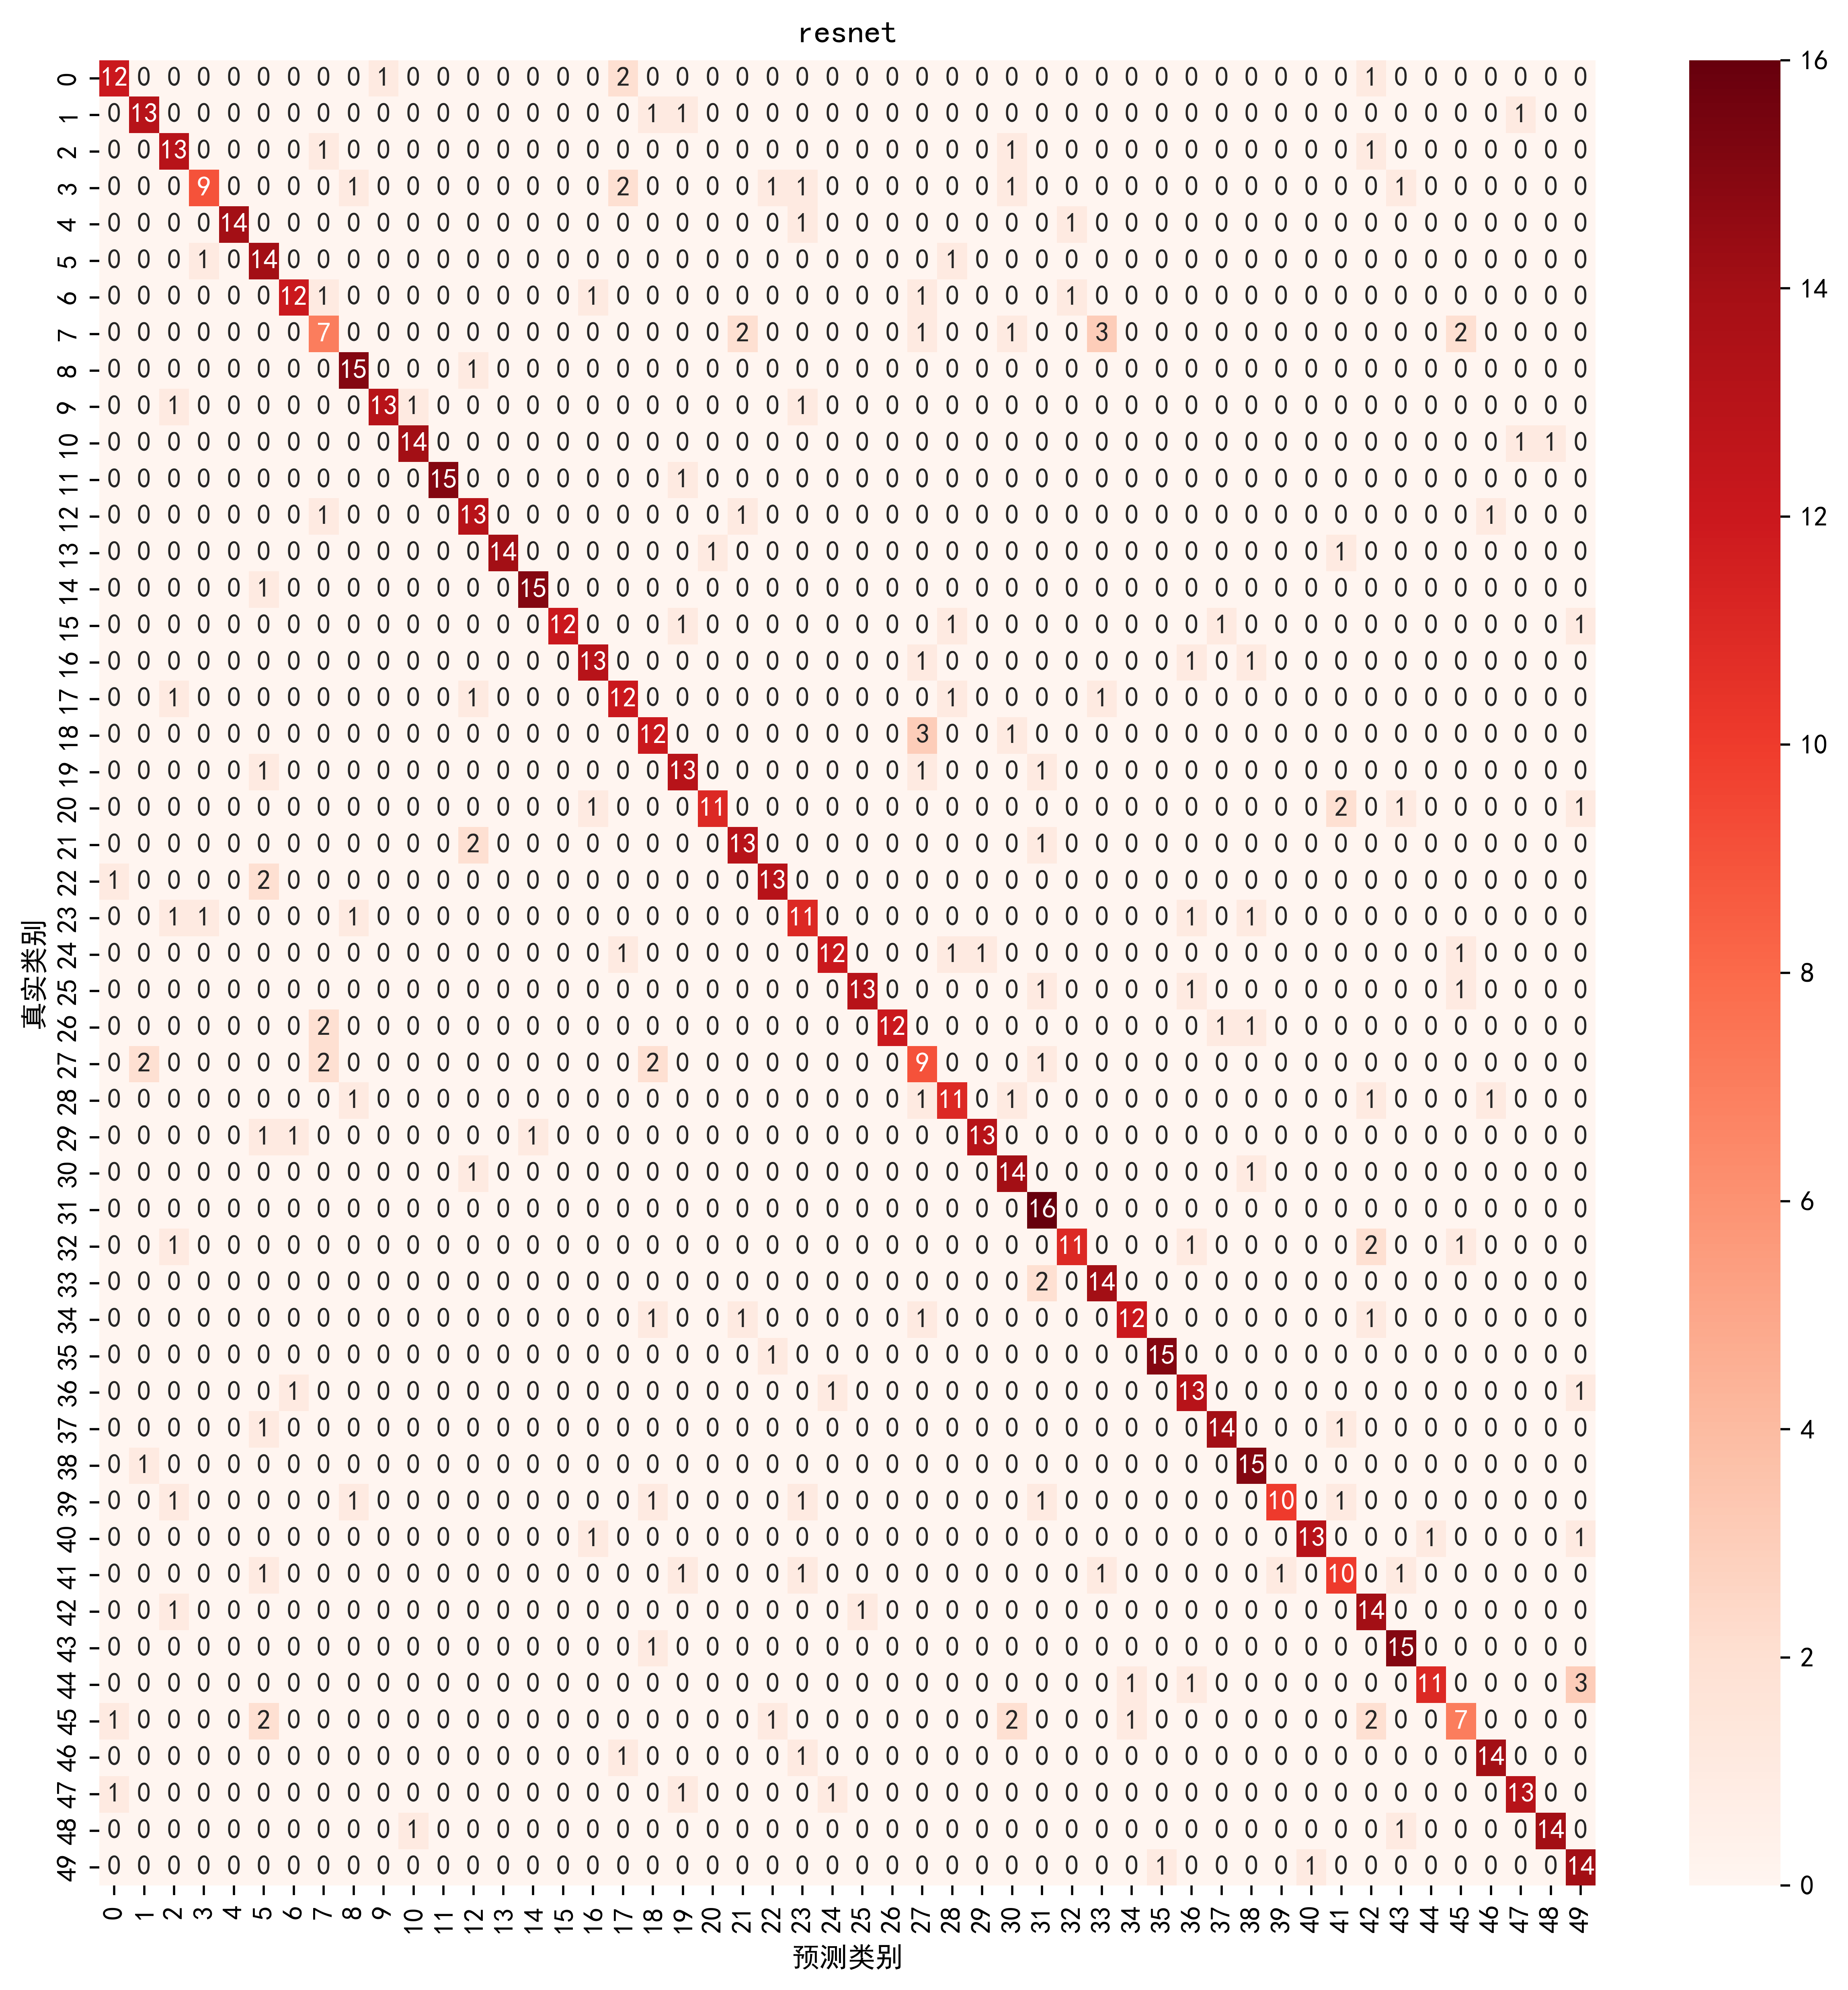

model_name: resnet
acc: 0.7900, F1 score: 0.7904, avg_confidence: 86.9183, avg_inference_time: 0.0070
use : vit


100%|██████████| 800/800 [00:06<00:00, 132.95it/s]


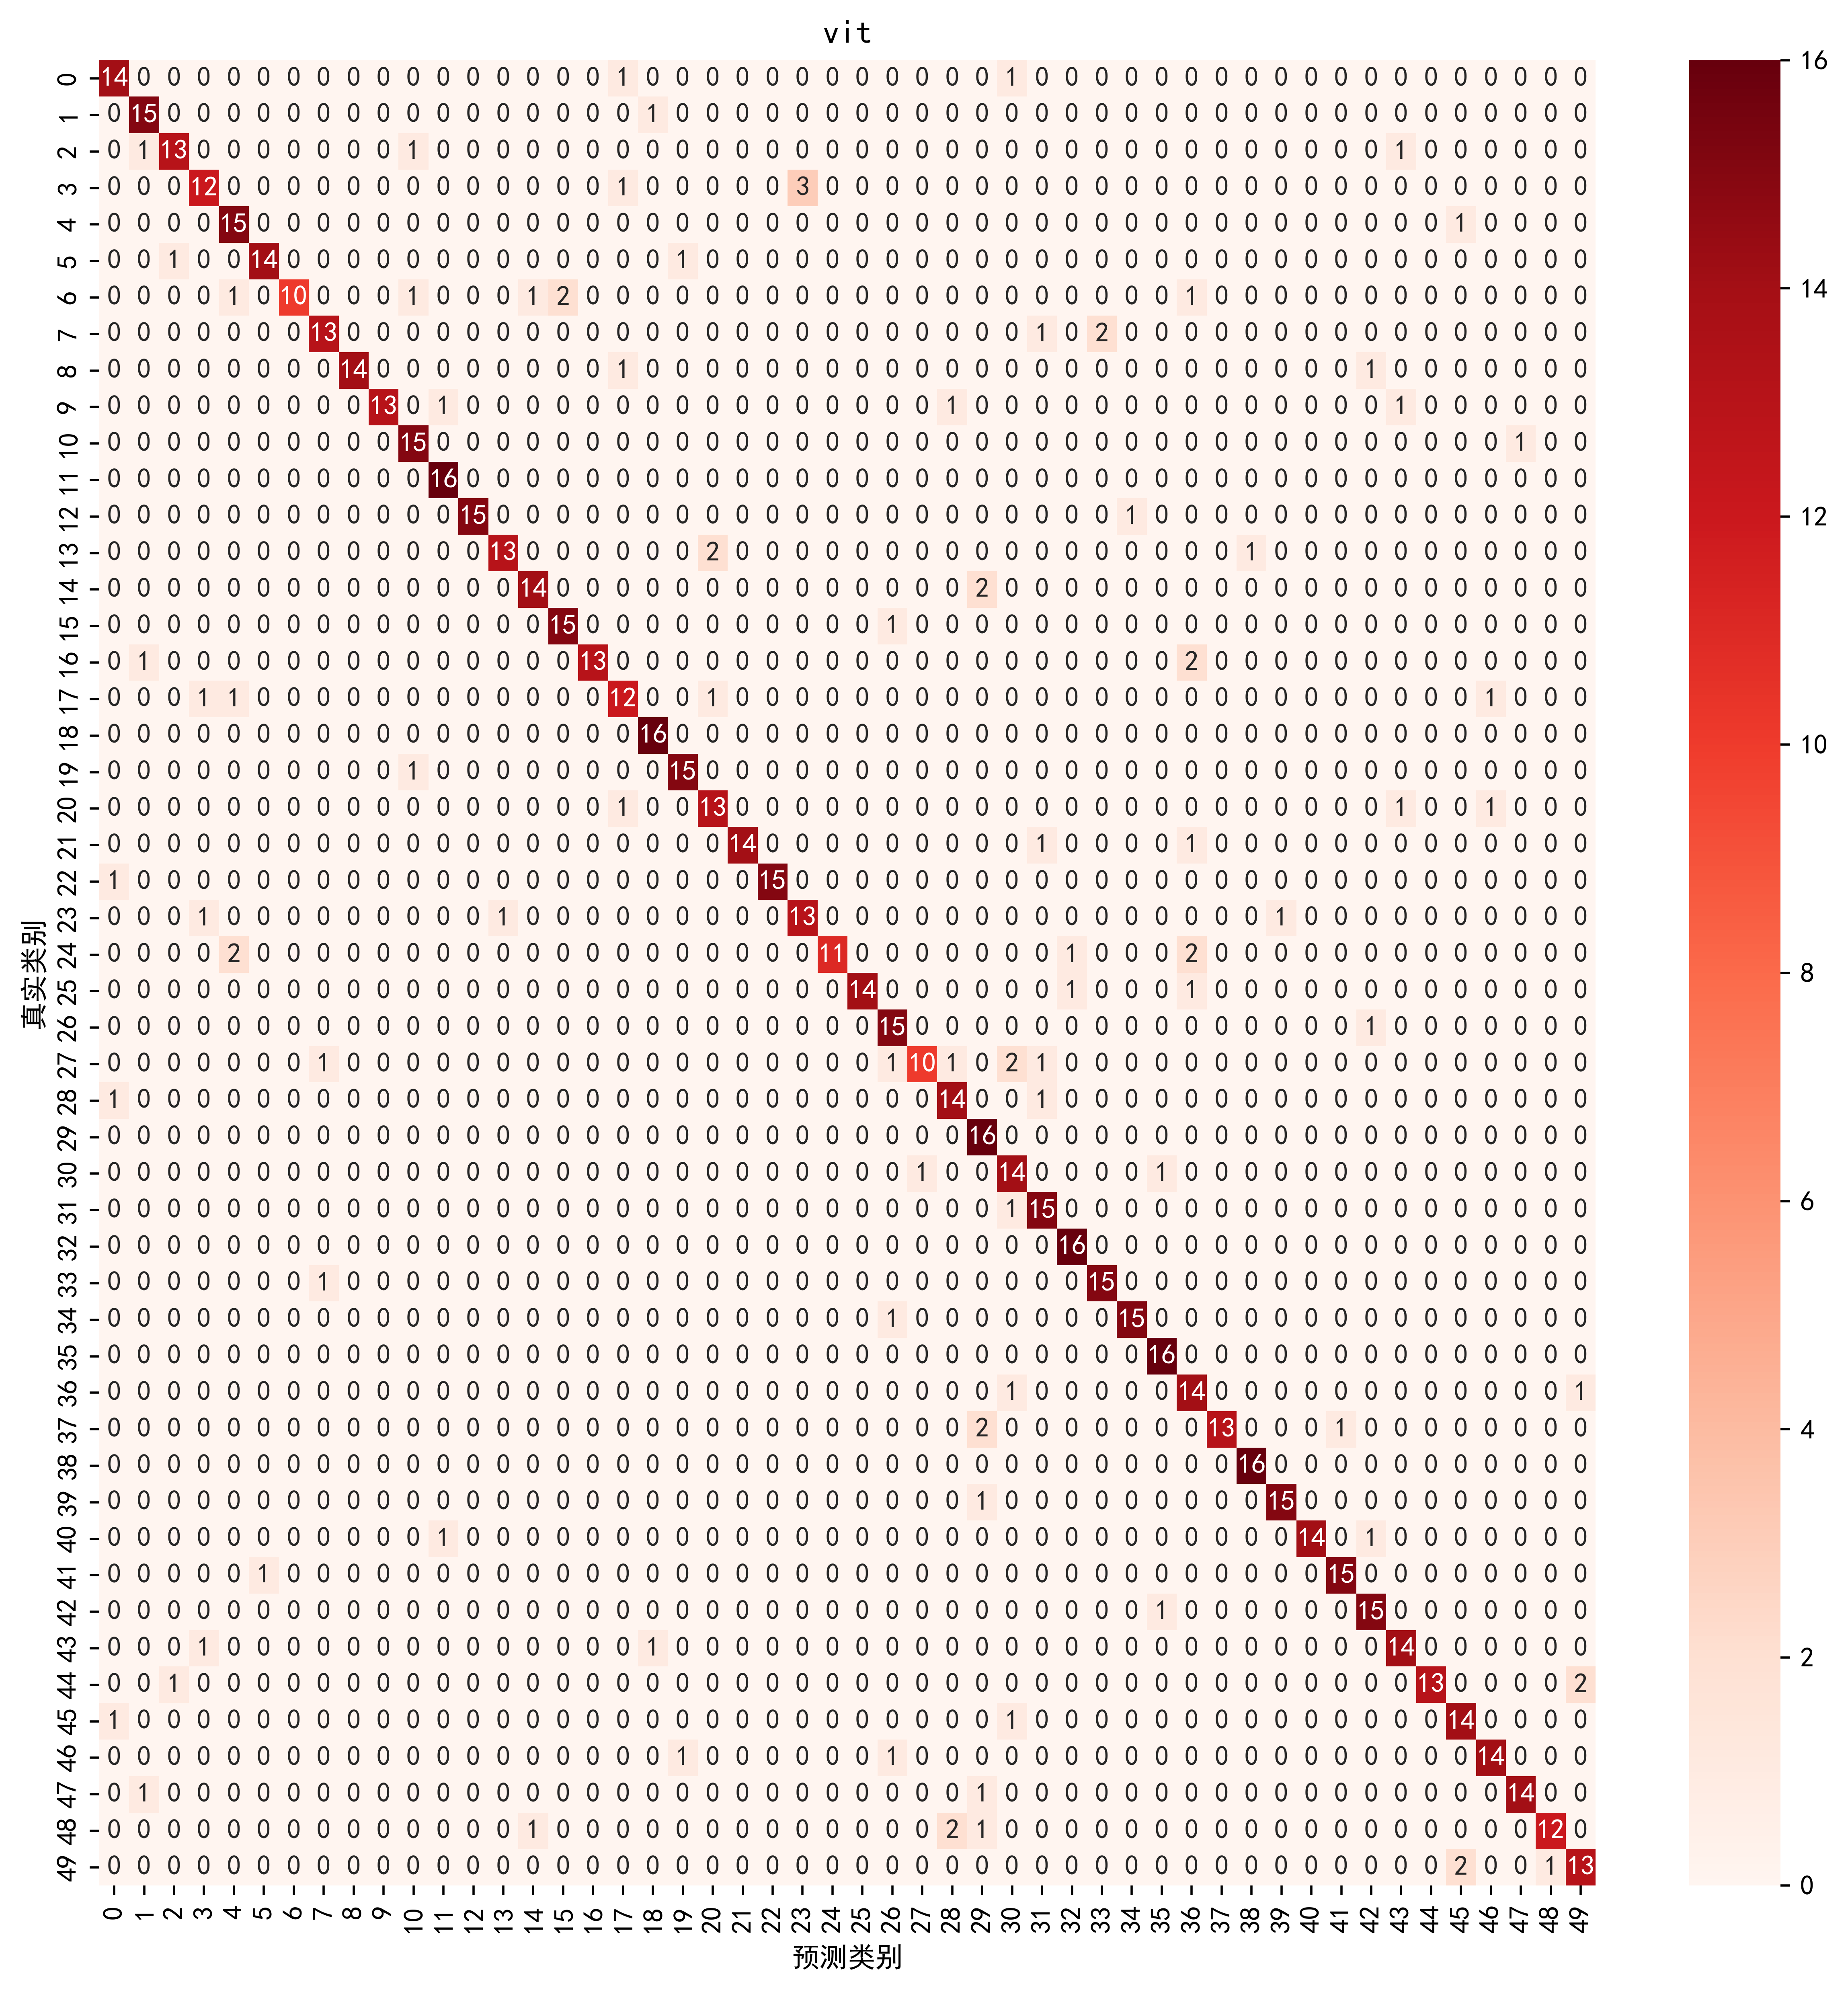

model_name: vit
acc: 0.8738, F1 score: 0.8737, avg_confidence: 92.0965, avg_inference_time: 0.0074


In [8]:
work("vgg")
work("resnet")
work("vit")

In [7]:
def get_flops_params(model_name):
    engine = InferenceEngine(model_name)

    image_path = r"../dataset/val-50/img-0-212t1.jpg"
    image = Image.open(image_path).convert("RGB")
    image_tensor = engine.transform(image).unsqueeze(0).to(engine.device)

    with torch.no_grad():
        flops, params = profile(engine.model, inputs=(image_tensor,))
    print(f"model: {model_name} FLOPs: {flops / 1e9:.3f} G", f"Params: {params / 1e6:.3f} M")

get_flops_params("vgg")
get_flops_params("resnet")
get_flops_params("vit")


use : vgg
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
model: vgg FLOPs: 20.235 G Params: 134.474 M
use : resnet
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'tor